# Injecting signals with a pre-determined SNR
This tutorial walks through created injected signals with a target signal-to-noise ratio (SNR).

If you have access to a GPU, it is highly recommended to install CuPy, which performs the equivalent NumPy array operations on the GPU (https://docs.cupy.dev/en/stable/install.html). This is not necessary to run raw voltage generation, but will highly accelerate the pipeline. Once you have CuPy installed, to enable GPU acceleration you must set `SETIGEN_ENABLE_GPU` to '1' in the shell or in Python via `os.environ`. It can also be useful to set `CUDA_VISIBLE_DEVICES` to specify which GPUs to use.

In [1]:
# !pip install cupy-cuda110

In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import setigen as stg

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [3]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

Blocks: 100%|██████████| 1/1 [00:13<00:00, 13.40s/it]     

working stem: example_snr
opening file: example_snr.0000.raw


opening file: example_snr.0001.raw [No such file or directory]
output product 0: 256 spectra


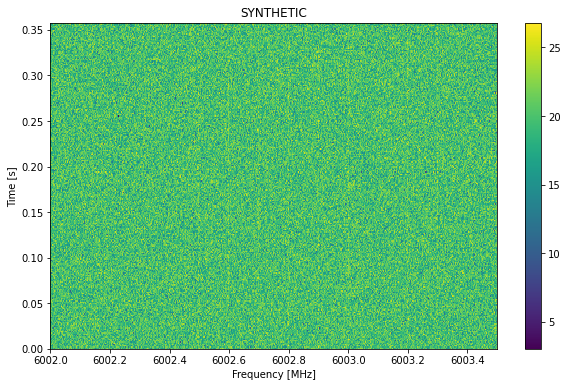

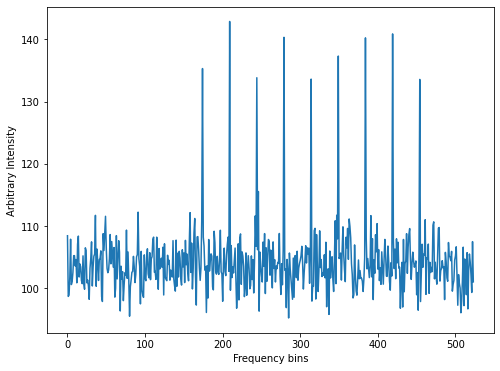

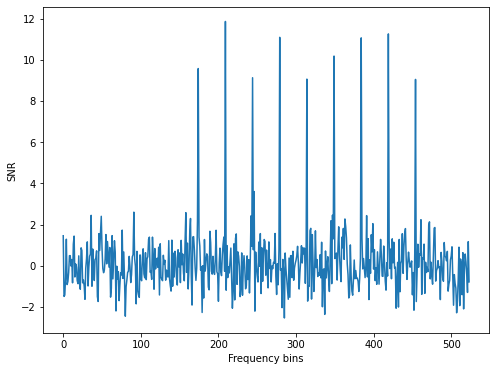

In [4]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=1)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

for stream in antenna.streams:
    stream.add_noise(v_mean=0, 
                     v_std=1)
    
fftlength = 1024
num_blocks = 1

signal_level = stg.voltage.get_level(snr=10, 
                                     raw_voltage_backend=rvb,
                                     fftlength=fftlength,
                                     num_blocks=num_blocks,
                                     length_mode='num_blocks')

df = chan_bw / fftlength
for f_start in np.linspace(6002.5e6, 6003.3e6, 9): 
    f_start = 6e9 + int((f_start - 6e9) / df) * df
    
    for stream in antenna.streams:
        stream.add_constant_signal(f_start=f_start, 
                                   drift_rate=0, 
                                   level=signal_level)
        
rvb.record(output_file_stem='example_snr',
           num_blocks=num_blocks, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

!rawspec -f $fftlength -t 4 -d . example_snr

wf = bl.Waterfall('example_snr.rawspec.0000.fil',
                  f_start=6002.0,
                  f_stop=6003.5)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate(frame)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('Arbitrary Intensity')
plt.show()

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

Blocks: 100%|██████████| 1/1 [00:12<00:00, 12.34s/it]     

working stem: example_snr
opening file: example_snr.0000.raw


opening file: example_snr.0001.raw [No such file or directory]
output product 0: 512 spectra


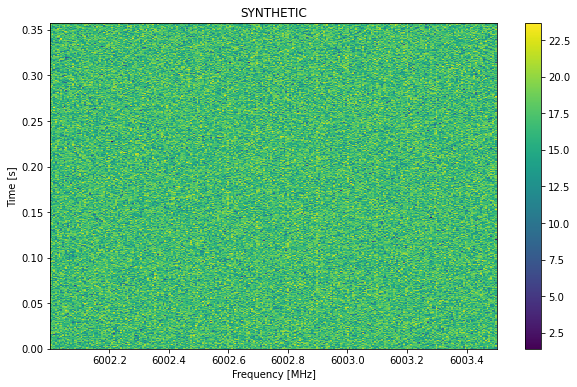

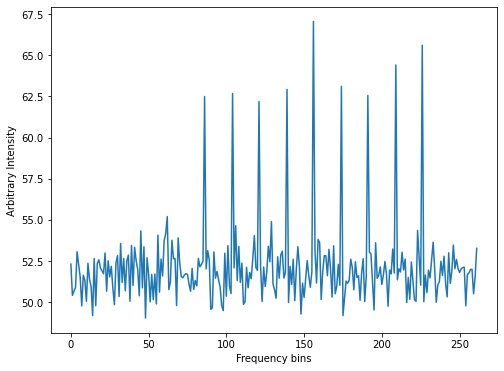

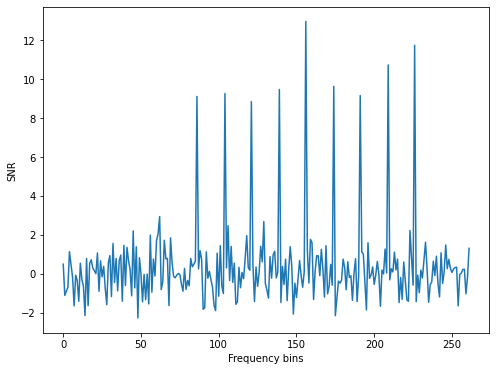

In [5]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=1)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=64)

for stream in antenna.streams:
    stream.add_noise(v_mean=0, 
                     v_std=1)
    
fftlength = 512
num_blocks = 1

signal_level = stg.voltage.get_level(snr=10, 
                                     raw_voltage_backend=rvb,
                                     fftlength=fftlength,
                                     num_blocks=num_blocks,
                                     length_mode='num_blocks')

df = chan_bw / fftlength
for f_start in np.linspace(6002.5e6, 6003.3e6, 9): 
    f_start = 6e9 + int((f_start - 6e9) / df) * df
    
    for stream in antenna.streams:
        stream.add_constant_signal(f_start=f_start, 
                                   drift_rate=0, 
                                   level=signal_level)
        
rvb.record(output_file_stem='example_snr',
           num_blocks=num_blocks, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

!rawspec -f $fftlength -t 4 -d . example_snr

wf = bl.Waterfall('example_snr.rawspec.0000.fil',
                  f_start=6002.0,
                  f_stop=6003.5)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate(frame)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('Arbitrary Intensity')
plt.show()

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()